In [64]:
import numpy as np
import pandas as pd 
import plotly.express as px

import sys
sys.path.append("../utils")
from parse_torch_profiler import txt_to_pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
full_pipeline = txt_to_pd('../timing/lightning_logs/acat_fullPipeline/predict-full.txt')
from_pc = txt_to_pd("../timing/lightning_logs/acat_fromPointCloud/predict-full.txt")
ml = txt_to_pd("../timing/lightning_logs/acat_ml_only_1000/predict-gc.txt")

3.11 minutes
5.14 seconds 
17.35 seconds for ml only 

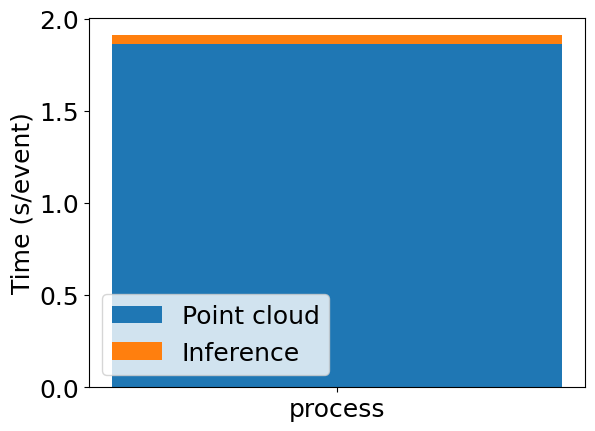

In [66]:
time_full = np.timedelta64(full_pipeline.iloc[0]['CPU total'], 's').astype('int')/100
time_inference = np.timedelta64(from_pc.iloc[0]['CPU total'], 's').astype('int')/100
name = [""]

mpl.rcParams.update({'font.size': 18})
plt.bar("process", time_full-time_inference, label="Point cloud")
plt.bar("process", time_inference, bottom=(time_full-time_inference), label="Inference")
plt.ylabel("Time (s/event)")
plt.legend()
plt.savefig("gnn_timing.png", dpi=800)

In [3]:

#gc_timing  = txt_to_pd('../timing/lightning_logs/gc/predict-gc.txt')
#oc_timing  = txt_to_pd('../timing/lightning_logs/oc/predict-oc.txt')
#ec_timing  = txt_to_pd('../timing/lightning_logs/ec/predict-ec.txt')



FileNotFoundError: [Errno 2] No such file or directory: '../timing/lightning_logs/gc/predict-gc.txt'

In [7]:
def get_costly_fns_wo_overhead(df, percentage, time_unit, num_samples): 
    """
    Function to calculate costly fns without overhead
    :param df: input df processed by the txt_to_pd function 
    :param percentage: only consider functions that take above the percentage of the time on CPU/GPU
    :param time_unit: unit of time 
    :return: costly CPU & GPU fns: a df with costly fns
    :return other_cpu/gpu_time : the time without overhead that is spent in other functions than the costly ones 
    """
    df_wo_overhead = df.iloc[2:]

    df_wo_overhead['Self CPU per sample'] = df_wo_overhead['Self CPU']/num_samples
    df_wo_overhead['Self CUDA per sample'] = df_wo_overhead['Self CUDA']/num_samples
    
    total_cpu_self_time_per_sample = np.timedelta64(df_wo_overhead['Self CPU per sample'].sum(), time_unit)
    total_gpu_self_time_per_sample = np.timedelta64(df_wo_overhead['Self CUDA per sample'].sum(), time_unit)

    df_wo_overhead['Self CPU per sample'] = df_wo_overhead['Self CPU per sample'].astype(f'timedelta64[{time_unit}]')
    df_wo_overhead['Self CUDA per sample'] = df_wo_overhead['Self CUDA per sample'].astype(f'timedelta64[{time_unit}]')
    costly_CPU_fns = df_wo_overhead[df_wo_overhead['Self CPU per sample'] > total_cpu_self_time_per_sample * percentage/100]
    costly_GPU_fns = df_wo_overhead[df_wo_overhead['Self CUDA per sample'] > total_gpu_self_time_per_sample * percentage/100] 
    
    other_cpu_time = np.timedelta64(total_cpu_self_time_per_sample - costly_CPU_fns['Self CPU per sample'].sum(), time_unit)
    other_gpu_time = np.timedelta64(total_gpu_self_time_per_sample - costly_GPU_fns['Self CUDA per sample'].sum(), time_unit)
        
    return costly_CPU_fns, costly_GPU_fns, other_cpu_time, other_gpu_time

In [76]:
import plotly.io as pio

def plot_timings(timing_df, percentage, time_unit, name, num_samples): 
    """
    Plot the CPU and GPU times as a bar chart

    Note: be careful! 

    """
    
    cpu, gpu, total_cpu, total_gpu = get_costly_fns_wo_overhead(timing_df, percentage, time_unit, num_samples)
    names = np.concatenate((cpu['Name'].values , ['totalCPU'], gpu['Name'].values, ['totalGPU']))
    #cpu_timings = np.array(cpu['Self CPU per sample'], 
    #print(cpu)
    timing = np.array(np.concatenate((cpu['Self CPU per sample'].values , [total_cpu], gpu['Self CUDA per sample'].values, [total_gpu])), dtype=int)
    device  = np.concatenate((['CPU']*(len(cpu)+1), ['GPU']*(len(gpu)+1))) 
    df_metric = pd.DataFrame({'names': names, 'type': device, 'timing': timing})
    #print(df_metric)
    fig = px.bar(df_metric, x="type", y="timing", color=names, 
                 labels={'type':'Device', 'timing':'Time (' + time_unit +' /event)', 'color':'Process'}, template='ggplot2')
    fig.update_layout(
        autosize=False,
        width=550,
        height=300,
        font=dict(
            size=20,  # Set the font size here
        )
    )

    fig.show()
    #fig.write_image("/Users/liv/gnn_performance_analysis/plotting/"+ name+"_timing.png", scale=6)
    pio.write_image(fig, 'image.pdf',scale=2, width=550, height=300)

    

In [77]:
plot_timings(from_pc.drop([3, 8]), 15, 'ms', 'full', 100)

/var/folders/fp/5tqzs2jn7fgbdzfwyp_qjkmr0000gn/T/ipykernel_45126/1178089202.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fp/5tqzs2jn7fgbdzfwyp_qjkmr0000gn/T/ipykernel_45126/1178089202.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fp/5tqzs2jn7fgbdzfwyp_qjkmr0000gn/T/ipykernel_45126/1178089202.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [34]:
steps = ["Point clouds", "Pipeline", "DBSCAN"]



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 4.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
full_pipeline.drop(3)

,Name,Self CPU %,Self CPU,CPU total %,CPU total,CPU time avg,Self CUDA,Self CUDA %,CUDA total,CUDA time avg,...,Self CUDA Mem,# of Calls,CPU Mem_number,CPU Mem_unit,Self CPU Mem_number,Self CPU Mem_unit,CUDA Mem_number,CUDA Mem_unit,Self CUDA Mem_number,Self CUDA Mem_unit
0,ProfilerStep*,0.06,0 days 00:00:00.108532,100.00,0 days 00:03:11.816000,0 days 00:00:01.918000,0 days 00:00:00,0.00,0 days 00:03:18.293000,0 days 00:00:01.983000,...,-2.26 Gb,100,1.03,Gb,-32.94,Mb,-41.97,Mb,-2.26,Gb
1,[pl][profile][Strategy]SingleDeviceStrategy.pr...,-0.18,-1 days +23:59:59.996371,99.59,0 days 00:03:11.031000,0 days 00:00:01.930000,0 days 00:00:00,0.00,0 days 00:03:16.160000,0 days 00:00:01.981000,...,-2037.62 Gb,99,0.00,b,0.00,b,1.01,Gb,-2037.62,Gb
2,torch_cluster::knn,0.00,0 days 00:00:00.006578,75.08,0 days 00:02:24.016000,0 days 00:00:01.455000,0 days 00:02:21.944000,74.86,0 days 00:02:22.679000,0 days 00:00:01.441000,...,-10.33 Gb,99,0.00,b,0.00,b,5.01,Gb,-10.33,Gb
4,[pl][module]gnn_tracking.models.resin.ResIN: m...,0.04,0 days 00:00:00.077237,1.49,0 days 00:00:02.863000,0 days 00:00:00.028919,0 days 00:00:00,0.00,0 days 00:00:43.279000,0 days 00:00:00.437162,...,-4217.96 Gb,99,0.00,b,0.00,b,201.32,Gb,-4217.96,Gb
5,aten::linear,0.01,0 days 00:00:00.014506,0.49,0 days 00:00:00.932166,0 days 00:00:00.000235395,0 days 00:00:00,0.00,0 days 00:00:32.480000,0 days 00:00:00.008202,...,-1148.08 Gb,3960,0.00,b,0.00,b,1804.75,Gb,-1148.08,Gb
6,forward,0.01,0 days 00:00:00.010481,0.77,0 days 00:00:01.470000,0 days 00:00:00.001856,0 days 00:00:00,0.00,0 days 00:00:31.387000,0 days 00:00:00.039631,...,-895.44 Gb,792,0.00,b,0.00,b,810.32,Gb,-895.44,Gb
7,aten::addmm,0.05,0 days 00:00:00.088928,0.45,0 days 00:00:00.853623,0 days 00:00:00.000287415,0 days 00:00:27.668000,14.59,0 days 00:00:29.296000,0 days 00:00:00.009864,...,2448.08 Gb,2970,0.00,b,0.00,b,2447.83,Gb,2448.08,Gb
8,ampere_sgemm_64x64_tn,0.00,0 days 00:00:00,0.00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:27.156000,14.32,0 days 00:00:27.156000,0 days 00:00:00.004676,...,0 b,5808,0.00,b,0.00,b,0.00,b,0.00,b
9,[pl][module]gnn_tracking.models.interaction_ne...,0.02,0 days 00:00:00.033033,0.79,0 days 00:00:01.514000,0 days 00:00:00.015291,0 days 00:00:00,0.00,0 days 00:00:11.090000,0 days 00:00:00.112018,...,-991.42 Gb,99,0.00,b,0.00,b,201.32,Gb,-991.42,Gb
10,aten::index_select,0.01,0 days 00:00:00.022611,0.03,0 days 00:00:00.049780,0 days 00:00:00.000062854,0 days 00:00:05.573000,2.94,0 days 00:00:05.616000,0 days 00:00:00.007091,...,0 b,792,0.00,b,0.00,b,1548.52,Gb,0.00,b


In [24]:
gc_timing[~gc_timing['Name'].str.contains('_MultiProcessingDataLoad')]

,Name,Self CPU %,Self CPU,CPU total %,CPU total,CPU time avg,Self CUDA,Self CUDA %,CUDA total,CUDA time avg,...,Self CUDA Mem,# of Calls,CPU Mem_number,CPU Mem_unit,Self CPU Mem_number,Self CPU Mem_unit,CUDA Mem_number,CUDA Mem_unit,Self CUDA Mem_number,Self CUDA Mem_unit
0,ProfilerStep*,3.51,0 days 00:00:00.463859,100.00,0 days 00:00:13.231000,0 days 00:00:00.013231,0 days 00:00:00,0.00,0 days 00:00:00.937428,0 days 00:00:00.000937428,...,-689.64 Mb,1000,-257.81,Kb,-257.81,Kb,98.50,Kb,-689.64,Mb
1,[pl][profile][_EvaluationLoop].test_next,0.22,0 days 00:00:00.029611,81.16,0 days 00:00:10.739000,0 days 00:00:00.010739,0 days 00:00:00,0.00,0 days 00:00:00.023994,0 days 00:00:00.000023994,...,0 b,1000,0.00,b,0.00,b,0.00,b,0.00,b
3,[pl][profile][Strategy]SingleDeviceStrategy.te...,2.57,0 days 00:00:00.340660,8.30,0 days 00:00:01.098000,0 days 00:00:00.001098,0 days 00:00:00,0.00,0 days 00:00:00.837151,0 days 00:00:00.000837151,...,-190.68 Gb,1000,0.00,b,248.00,b,0.00,b,-190.68,Gb
4,[pl][profile][Strategy]SingleDeviceStrategy.ba...,0.48,0 days 00:00:00.064053,4.02,0 days 00:00:00.531606,0 days 00:00:00.000531606,0 days 00:00:00,0.00,0 days 00:00:00.076283,0 days 00:00:00.000076283,...,0 b,1000,0.00,b,0.00,b,689.74,Mb,0.00,b
5,[pl][profile][LightningModule]MLModule.transfe...,0.62,0 days 00:00:00.081671,3.47,0 days 00:00:00.458594,0 days 00:00:00.000458594,0 days 00:00:00,0.00,0 days 00:00:00.076283,0 days 00:00:00.000076283,...,-57.13 Mb,1000,0.00,b,0.00,b,689.74,Mb,-57.13,Mb
6,aten::to,0.28,0 days 00:00:00.036754,2.60,0 days 00:00:00.343489,0 days 00:00:00.000026422,0 days 00:00:00,0.00,0 days 00:00:00.067086,0 days 00:00:00.000005160,...,57.13 Mb,13000,0.00,b,0.00,b,689.74,Mb,57.13,Mb
7,[pl][profile][Callback]TQDMProgressBar.on_test...,2.55,0 days 00:00:00.336990,2.55,0 days 00:00:00.336990,0 days 00:00:00.000336990,0 days 00:00:00,0.00,0 days 00:00:00,0 days 00:00:00,...,0 b,1000,0.00,b,0.00,b,0.00,b,0.00,b
8,aten::_to_copy,0.33,0 days 00:00:00.043561,2.50,0 days 00:00:00.330814,0 days 00:00:00.000025447,0 days 00:00:00,0.00,0 days 00:00:00.072690,0 days 00:00:00.000005592,...,0 b,13000,0.00,b,0.00,b,689.74,Mb,0.00,b
9,aten::linear,0.13,0 days 00:00:00.017513,2.11,0 days 00:00:00.279777,0 days 00:00:00.000046630,0 days 00:00:00,0.00,0 days 00:00:00.659247,0 days 00:00:00.000109874,...,129.21 Mb,6000,0.00,b,0.00,b,43.53,Gb,129.21,Mb
10,aten::matmul,0.08,0 days 00:00:00.010903,1.77,0 days 00:00:00.234416,0 days 00:00:00.000039069,0 days 00:00:00,0.00,0 days 00:00:00.661651,0 days 00:00:00.000110275,...,43.77 Mb,6000,0.00,b,0.00,b,43.53,Gb,43.77,Mb


In [22]:
get_costly_fns_wo_overhead(oc_timing, 15, 'ms')


NameError: name 'oc_timing' is not defined

In [115]:
get_costly_fns_wo_overhead(ec_timing, 15, 'ms')

/var/folders/fp/5tqzs2jn7fgbdzfwyp_qjkmr0000gn/T/ipykernel_14973/1891507877.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fp/5tqzs2jn7fgbdzfwyp_qjkmr0000gn/T/ipykernel_14973/1891507877.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(              Name  Self CPU %               Self CPU  CPU total %  \
 2  cudaMemcpyAsync       24.98 0 days 00:00:00.381000        24.98   
 
                CPU total              CPU time avg Self CUDA  Self CUDA %  \
 2 0 days 00:00:00.381823 0 days 00:00:00.000073896    0 days          0.0   
 
   CUDA total CUDA time avg  # of Calls  
 2     0 days        0 days        5167  ,
                  Name  Self CPU %               Self CPU  CPU total %  \
 4  torch_cluster::knn        0.04 0 days 00:00:00.000612        22.01   
 
                CPU total           CPU time avg              Self CUDA  \
 4 0 days 00:00:00.336391 0 days 00:00:00.012459 0 days 00:00:00.322000   
 
    Self CUDA %             CUDA total          CUDA time avg  # of Calls  
 4        93.31 0 days 00:00:00.323970 0 days 00:00:00.011999          27  ,
 numpy.timedelta64(118,'ms'),
 numpy.timedelta64(15,'ms'))

In [113]:
percentage = 15 
num_samples = 1000
time_unit ='ms'
df_wo_overhead = gc_timing.iloc[2:]

df_wo_overhead['Self CPU per sample'] = df_wo_overhead['Self CPU']/num_samples
df_wo_overhead['Self CUDA per sample'] = df_wo_overhead['Self CUDA']/num_samples

    
total_cpu_self_time_per_sample = np.timedelta64(df_wo_overhead['Self CPU per sample'].sum(), time_unit)
total_gpu_self_time_per_sample = np.timedelta64(df_wo_overhead['Self CUDA per sample'].sum(), time_unit)

costly_CPU_fns = df_wo_overhead[df_wo_overhead['Self CPU per sample'] > total_cpu_self_time_per_sample * percentage/100]
costly_GPU_fns = df_wo_overhead[df_wo_overhead['Self CUDA per sample'] > total_gpu_self_time_per_sample * percentage/100]
costly_CPU_fns['Self CPU per sample'] = costly_CPU_fns['Self CPU per sample'].astype(f'timedelta64[{time_unit}]')
costly_GPU_fns['Self CUDA per sample'] = costly_GPU_fns['Self CUDA per sample'].astype(f'timedelta64[{time_unit}]')


other_cpu_time = np.timedelta64(total_cpu_self_time_per_sample - costly_CPU_fns['Self CPU per sample'].sum(), time_unit)
other_gpu_time = np.timedelta64(total_gpu_self_time_per_sample - costly_GPU_fns['Self CUDA per sample'].sum(), time_unit)

/tmp/ipykernel_2924304/4132770040.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2924304/4132770040.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2924304/4132770040.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
total_cpu_self_time_per_sample

numpy.timedelta64(1,'ms')

In [115]:
np.timedelta64(costly_CPU_fns['Self CPU per sample'].sum(), 'us')

numpy.timedelta64(0,'us')

In [116]:
other_cpu_time

numpy.timedelta64(1,'ms')

In [117]:
costly_GPU_fns

,Name,Self CPU %,Self CPU,CPU total %,CPU total,CPU time avg,Self CUDA,Self CUDA %,CUDA total,CUDA time avg,...,CPU Mem_number,CPU Mem_unit,Self CPU Mem_number,Self CPU Mem_unit,CUDA Mem_number,CUDA Mem_unit,Self CUDA Mem_number,Self CUDA Mem_unit,Self CPU per sample,Self CUDA per sample
7,aten::copy_,0.53,0 days 00:00:00.069086,3.89,0 days 00:00:00.502651,0 days 00:00:00.000035904,0 days 00:00:00.064603,7.65,0 days 00:00:00.102950,0 days 00:00:00.000007354,...,0.0,b,0.0,b,0.00,b,0.00,b,0 days 00:00:00.000069086,0 days
9,cudaMemcpyAsync,2.48,0 days 00:00:00.319978,2.48,0 days 00:00:00.319978,0 days 00:00:00.000024614,0 days 00:00:00.019679,2.33,0 days 00:00:00.019679,0 days 00:00:00.000001514,...,0.0,b,0.0,b,0.00,b,0.00,b,0 days 00:00:00.000319978,0 days
13,aten::mm,1.12,0 days 00:00:00.144733,1.59,0 days 00:00:00.205446,0 days 00:00:00.000034241,0 days 00:00:00.636293,75.36,0 days 00:00:00.663289,0 days 00:00:00.000110548,...,0.0,b,0.0,b,43.53,Gb,43.53,Gb,0 days 00:00:00.000144733,0 days
14,aten::mul,0.75,0 days 00:00:00.097169,1.10,0 days 00:00:00.142671,0 days 00:00:00.000015852,0 days 00:00:00.059335,7.03,0 days 00:00:00.073782,0 days 00:00:00.000008198,...,128.0,b,128.0,b,69.37,Gb,69.37,Gb,0 days 00:00:00.000097169,0 days
15,cudaLaunchKernel,1.10,0 days 00:00:00.142059,1.10,0 days 00:00:00.142059,0 days 00:00:00.000005145,0 days 00:00:00.039995,4.74,0 days 00:00:00.039995,0 days 00:00:00.000001449,...,0.0,b,0.0,b,0.00,b,0.00,b,0 days 00:00:00.000142059,0 days
16,cudaStreamSynchronize,0.88,0 days 00:00:00.113587,0.88,0 days 00:00:00.113587,0 days 00:00:00.000008737,0 days 00:00:00.018668,2.21,0 days 00:00:00.018668,0 days 00:00:00.000001436,...,0.0,b,0.0,b,0.00,b,0.00,b,0 days 00:00:00.000113587,0 days
17,aten::clamp_min,0.41,0 days 00:00:00.052677,0.62,0 days 00:00:00.079594,0 days 00:00:00.000013266,0 days 00:00:00.035389,4.19,0 days 00:00:00.042878,0 days 00:00:00.000007146,...,0.0,b,0.0,b,43.06,Gb,43.06,Gb,0 days 00:00:00.000052677,0 days


In [84]:
other_cpu_time

numpy.timedelta64(721,'us')